# Processing Sequences Using RNNs and CNNs

## Different Sequences of RNNs
- Sequence to Sequence (ex. Forecast time series such as home's daily power consumption)
- Sequence to Vector (ex. Feed the model a sequence of words corresponding to a movie review and output a sentiment score vector (0 to 1))
- Vector to Sequence (ex. The input could be an image or output of a CNN, then the output is the caption for that image)
- <b>Encoder</b>(Sequence to Vector) to <b>Decoder</b>(Vector to Sequence) (ex. Useful for language translating)

## Training RNNs

RNNs use a strategy called backpropagation through time(BPTT) to train. This is very similar to regular backpropagation but instead you unravel the RNN through time(which means that you let it go through a couple of times instead of other NN where you do one forward pass then backprop) then calculate the gradients and make step. <b>Note: Sometimes the loss function for RNNs only looks at certain outputs and not all of the outputs through the time.

### Forcasting a Time Series

In [1]:
import pandas as pd
from pathlib import Path
path = Path('/home/misha/Desktop/data/ml_book_data/CTA_-_Ridership_-_Daily_Boarding_Totals_20250126.csv')
df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total']

In [2]:
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis=1)
df = df.drop_duplicates()

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


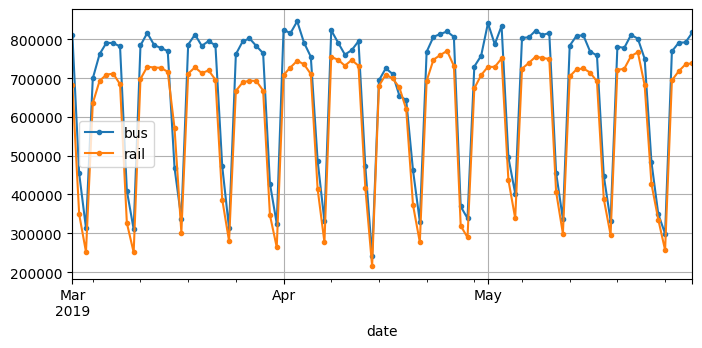

In [4]:
import matplotlib.pyplot as plt
df['2019-03': '2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

This is a time series: data with values at different time steps, usually at regular intervals. Since there are multiple values per time step, this is called a <b>multivariate time series</b>. If we only looked at the bus column, it would be a <b>univariate time series</b>, or a time series with a single value per time step.

<b>Naive forcasting</b> is when you just copy past values to make a forecast. This can be usful as a baseline and in some cases like this one where the data looks like it clearly repeats consitiantly, it can be difficult to beat.

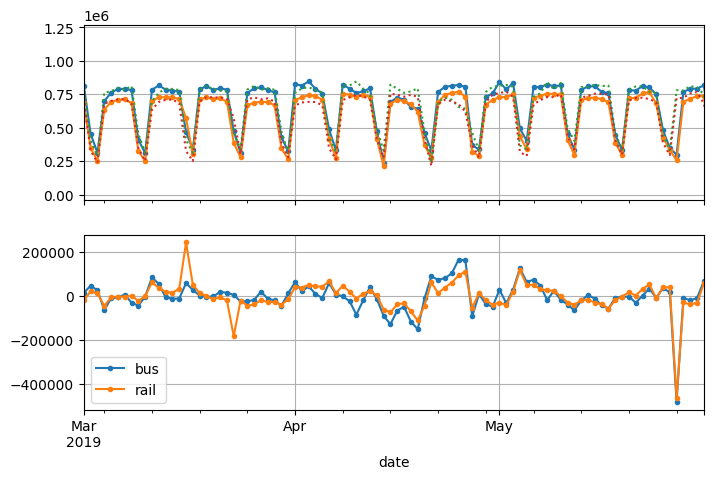

In [5]:
### Visualizing these naive forcasts by overlaying two time series lagged by a week
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,5))
df.plot(ax=axs[0], legend=False, marker='.')
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':')
diff_7.plot(ax=axs[1], grid=True, marker='.')
plt.show()

In [6]:
## Mean abs error (MAE)
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [7]:
## Mean abs percentage error (MAPE)
targets = df[['bus', 'rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

## The ARMA Model Family

The Autoregressive moving average(ARMA) model computes forecasts using a simple weighted sum of lagged values and corrects these forecasts by adding a moving average. This is a mathmatical model not a ML model

## Preparing the Data for ML Models

The goal of our ML model is to forecast tomorrow's ridership based on the ridership of the past 8 weeks of data(56 days). The input to the model will therefore be sequences containing 56 values. For each input sequence the model will output a single value: the forecast for time step t + 1. For the training data, we will use every 56-day window from the past as training data and the target for each window will be the value immediately following. 

In [8]:
import tensorflow as tf

2025-01-26 16:49:07.521756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 16:49:07.659432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737931747.715975    4486 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737931747.734739    4486 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 16:49:07.911756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [9]:
### Setting up training data using keras utils
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)

I0000 00:00:1737931749.722702    4486 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9666 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
list(my_dataset)

2025-01-26 16:49:09.903547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [11]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1): ## Add drop_remainder=True to get rid of smaller windows
    for element in window_dataset:
        print(f"{element}", end=' ')
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-01-26 16:49:09.920720: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-26 16:49:09.923231: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-26 16:49:09.927443: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-26 16:49:09.932239: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The .window method returns a nested dataset which is like a list of lists. However we can't use this for our model so we must call flat_map() to convert a nested dataset into a flat dataset(one that contains tensors, not datasets).

In [12]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [13]:
## Helper function to make this easier
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [14]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Now we have the same output like from the utils function

Now lets split into training, val, and test dataset

In [15]:
rail_train = df['rail']['2016-01':'2018-12'] / 1e6
rail_valid = df['rail']['2019-01':'2019-05'] / 1e6
rail_test = df['rail']['2019-06':] / 1e6

In [16]:
seq_len = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_len:],
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_len:],
    sequence_length=seq_len,
    batch_size=32
)

### Forecasting with a Linear Model

In [17]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(seq_len,))
])
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stop])

/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - loss: 0.3965 - mae: 0.8721

I0000 00:00:1737931751.460890    4556 service.cc:148] XLA service 0x79b0600054c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737931751.461018    4556 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-26 16:49:11.475149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737931751.504896    4556 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1737931751.605286    4556 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1303 - mae: 0.4266 - val_loss: 0.0157 - val_mae: 0.1398
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mae: 0.1412 - val_loss: 0.0101 - val_mae: 0.1152
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.1264 - val_loss: 0.0098 - val_mae: 0.1110
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - mae: 0.1182 - val_loss: 0.0076 - val_mae: 0.0950
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - mae: 0.0982 - val_loss: 0.0073 - val_mae: 0.0922
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - mae: 0.0966 - val_loss: 0.0064 - val_mae: 0.0856
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0871 - val_loss: 0.0055 - val_mae: 0.0763
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0805 - val_loss: 0.0052 - val_mae: 0.0738
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.

In [18]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - mae: 0.0390


37668.3846116066

### Forecasting with a Simple RNN

All recurrent layers in Keras expect 3D inputs of shape [batch_size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series. 

In [19]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(None, 1)),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stop])

Epoch 1/500


/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0601 - mae: 0.2747 - val_loss: 0.0232 - val_mae: 0.1551
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - mae: 0.1217 - val_loss: 0.0033 - val_mae: 0.0558
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0683 - val_loss: 0.0020 - val_mae: 0.0372
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0577 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0338
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0494 - val_loss: 0.0025 - val_mae: 0.0438
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0532 - val_loss: 0.0022 - val_mae: 0.0381
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0499 - val_loss: 0.0022 - val_mae: 0.0340
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.

In [20]:
# extra code – evaluates the model
valid_loss, valid_mae = univar_model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - mae: 0.0259    


29082.007706165314

### Forecasting with a Deep RNN

In [21]:
## Deep RNNs are simple, just stack recurrent layers
deep_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = deep_model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stop])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1610 - mae: 0.4209 - val_loss: 0.0153 - val_mae: 0.1559
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - mae: 0.1619 - val_loss: 0.0157 - val_mae: 0.1675
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180 - mae: 0.1614 - val_loss: 0.0187 - val_mae: 0.1162
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - mae: 0.1555 - val_loss: 0.0198 - val_mae: 0.1216
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - mae: 0.1427 - val_loss: 0.0102 - val_mae: 0.1277
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mae: 0.1302 - val_loss: 0.0108 - val_mae: 0.1271
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - mae: 0.1100 - val_loss: 0.0066 - val_mae: 0.0987
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0968 - val_loss: 0.0040 - val_mae: 0.0675
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.00

In [22]:
# extra code – evaluates the model
valid_loss, valid_mae = deep_model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - mae: 0.0269    


28665.311634540558

### Forecasting Multivariate Time Series

In [29]:
df_mulvar = df[['bus', 'rail']] / 1e6
df_mulvar['next_day_type'] = df['day_type'].shift(-1) # We know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)

In [30]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [31]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_len:],  # forecast only the rail series
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_len:],
    sequence_length=seq_len,
    batch_size=32
)

In [32]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

### Forecasting Several Time Steps Ahead

There are two ways to do this

The first way is to take an old model and instead of changing it, you just have it keep predicting the next value based on the previous predicted values.

In [33]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_len, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1,1,1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


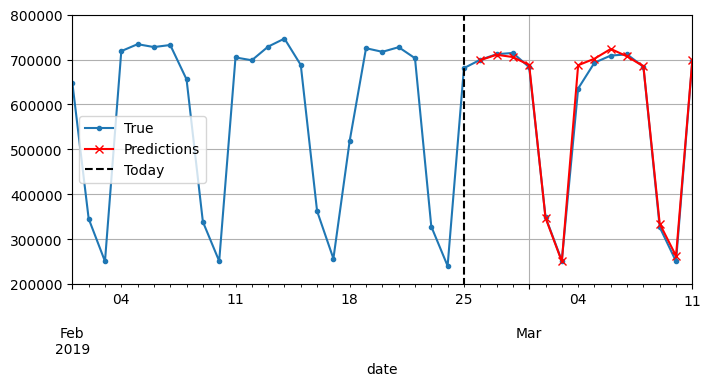

In [34]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

The second way is to train an RNN to predict the next 14 values in one shot. We can still use a sequence to vector model, but change the output to 14 values instead of 1. However this will require changes to the dataset.

In [36]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_len + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_len + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [37]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
ahead_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = ahead_model.fit(ahead_train_ds, validation_data=ahead_valid_ds, epochs=500,
                   callbacks=[early_stop])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2233 - mae: 0.5409 - val_loss: 0.0357 - val_mae: 0.2130
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0257 - mae: 0.1765 - val_loss: 0.0124 - val_mae: 0.1191
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - mae: 0.1219 - val_loss: 0.0084 - val_mae: 0.0977
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - mae: 0.1058 - val_loss: 0.0063 - val_mae: 0.0829
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0941 - val_loss: 0.0053 - val_mae: 0.0750
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - mae: 0.0875 - val_loss: 0.0046 - val_mae: 0.0687
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0811 - val_loss: 0.0039 - val_mae: 0.0643
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0767 - val_loss: 0.0037 - val_mae: 0.0620
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.00

This works but however a sequence to sequence model will work much better.

### Forecasting using a Sequence to Sequence Model

In [40]:
def to_seq2seq_dataset(series, seq_len=56, ahead=14, target_col=1,
                      batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_len).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [41]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [42]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

## Handling Long Sequences

Simple RNNs work well on shorter sequences but struggle with long sequences.

### Fighting the Unstable Gradients Problem

Many of the tricks from chapter 11 will work for RNNs. However, nonsaturating activation functions like ReLU may not help and may even make it worse. Moreover, Batch Normalization doesn't work as well with RNNs because you can't really put them in between the Recurrent cells just between the layers. Layer normalization does work well with RNNs. 

In [43]:
### RNN Cell with layer normalization
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                            activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outpus, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [45]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                       input_shape=(None, 5)),
    tf.keras.layers.Dense(14)
])

/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Tackling the Short-Term Memory Problem

Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN's state contains virtually no trace of the first inputs. To tackle this problem we have long-term memory cells.

#### LSTM Cells

Long short-term memory cells

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(None, 5)),
    tf.keras.layers.Dense(14)
])

#### GRU Cells

The gated recurrent unit cell is a variant of the LSTM cell

#### 1D Convolutional Layers to Process Sequences

1D conv layers work the same as 2D works on an image, by sliding several kernels across and making feature maps of them. 1D conv layers work well with very long sequence data like audio samples, long time series, or long sentences.

In [48]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                          activation='relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])
longer_train = to_seq2seq_dataset(mulvar_train, seq_len=112,
                                 shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_len=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
conv_rnn_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = conv_rnn_model.fit(downsampled_train, validation_data=downsampled_valid, epochs=500,
                   callbacks=[early_stop])

Epoch 1/500
     31/Unknown 2s 4ms/step - loss: 0.1376 - mae: 0.4599

2025-01-26 17:43:19.715697: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:19.715728: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:19.715734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:19.715736: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:19.715740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
/home/misha/Desktop/env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` bat

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1359 - mae: 0.4557 - val_loss: 0.0227 - val_mae: 0.1590
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - mae: 0.1617 - val_loss: 0.0194 - val_mae: 0.1515
Epoch 3/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - mae: 0.1583 

2025-01-26 17:43:20.074885: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-01-26 17:43:20.074907: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:20.074913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:20.074917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:20.074920: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:20.074923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:20.102107: I

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - mae: 0.1572 - val_loss: 0.0183 - val_mae: 0.1487
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - mae: 0.1540 - val_loss: 0.0176 - val_mae: 0.1463
Epoch 5/500


2025-01-26 17:43:20.289803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:20.289828: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:20.289832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:20.475413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - mae: 0.1512 - val_loss: 0.0170 - val_mae: 0.1439
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - mae: 0.1487 - val_loss: 0.0165 - val_mae: 0.1412
Epoch 7/500


2025-01-26 17:43:20.664623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:20.664644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:20.819981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:20.820004: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_13]]
2025-01-26 17:43:20.820017: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:20.820023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - mae: 0.1459 - val_loss: 0.0161 - val_mae: 0.1383
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - mae: 0.1429 - val_loss: 0.0155 - val_mae: 0.1361
Epoch 9/500


2025-01-26 17:43:21.032517: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:21.032537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:21.032542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:21.215566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:21.215589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:21.215594: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - mae: 0.1403 - val_loss: 0.0151 - val_mae: 0.1337
Epoch 10/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - mae: 0.1385 

2025-01-26 17:43:21.374621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:21.374641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:21.374645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:21.402778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:21.402797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:21.557951: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:21.557976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - mae: 0.1375 - val_loss: 0.0146 - val_mae: 0.1313
Epoch 11/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - mae: 0.1356 - val_loss: 0.0142 - val_mae: 0.1288
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - mae: 0.1327 - val_loss: 0.0138 - val_mae: 0.1264
Epoch 13/500


2025-01-26 17:43:21.767117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:21.767140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:21.946957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:21.946977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:21.946981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - mae: 0.1297 - val_loss: 0.0133 - val_mae: 0.1241
Epoch 14/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - mae: 0.1273 - val_loss: 0.0129 - val_mae: 0.1218
Epoch 15/500


2025-01-26 17:43:22.132647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:22.132667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:22.132671: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:22.287378: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-26 17:43:22.315472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:22.315495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:22.315500: I tensorflow/core/f

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - mae: 0.1244 - val_loss: 0.0125 - val_mae: 0.1196
Epoch 16/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - mae: 0.1216 - val_loss: 0.0121 - val_mae: 0.1176
Epoch 17/500


2025-01-26 17:43:22.507003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:22.507024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:22.507029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:22.667273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:22.667295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:22.667300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:22.694855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - mae: 0.1193 - val_loss: 0.0117 - val_mae: 0.1155
Epoch 18/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - mae: 0.1169 - val_loss: 0.0113 - val_mae: 0.1136
Epoch 19/500


2025-01-26 17:43:22.883234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:22.883256: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:22.883261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:23.072482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:23.072504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:23.072509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - mae: 0.1141 - val_loss: 0.0110 - val_mae: 0.1116
Epoch 20/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - mae: 0.1124 

2025-01-26 17:43:23.228345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:23.228368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:23.228372: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:23.255024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:23.255044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:23.255048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:23.411108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - mae: 0.1117 - val_loss: 0.0106 - val_mae: 0.1098
Epoch 21/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - mae: 0.1094 - val_loss: 0.0103 - val_mae: 0.1080
Epoch 22/500


2025-01-26 17:43:23.439580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:23.439608: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:23.439615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:23.594254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:23.594276: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:23.594281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:23.621506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - mae: 0.1078 - val_loss: 0.0101 - val_mae: 0.1062
Epoch 23/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.1056 

2025-01-26 17:43:23.771797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:23.797918: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:23.797938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:23.797942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.1052 - val_loss: 0.0098 - val_mae: 0.1046
Epoch 24/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - mae: 0.1034 - val_loss: 0.0095 - val_mae: 0.1031
Epoch 25/500


2025-01-26 17:43:23.979272: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:23.979297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:23.979302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:24.165299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:24.165319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:24.165323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - mae: 0.1018 - val_loss: 0.0093 - val_mae: 0.1016
Epoch 26/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mae: 0.1005 

2025-01-26 17:43:24.326289: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:24.326314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:24.326320: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:24.326322: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:24.326326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - mae: 0.0999 - val_loss: 0.0091 - val_mae: 0.1003
Epoch 27/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - mae: 0.0980 - val_loss: 0.0089 - val_mae: 0.0989
Epoch 28/500


2025-01-26 17:43:24.545930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:24.545950: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:24.729588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:24.729609: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0968 - val_loss: 0.0087 - val_mae: 0.0976
Epoch 29/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mae: 0.0952 - val_loss: 0.0085 - val_mae: 0.0965
Epoch 30/500


2025-01-26 17:43:24.916612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:24.916632: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:25.080898: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:25.080923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:25.080927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:25.111033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:25.111059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0942 - val_loss: 0.0084 - val_mae: 0.0955
Epoch 31/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0925 

2025-01-26 17:43:25.269654: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-26 17:43:25.296830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:25.296851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:25.296855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - mae: 0.0926 - val_loss: 0.0082 - val_mae: 0.0945
Epoch 32/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0917 

2025-01-26 17:43:25.490183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:25.490223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:25.490231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:25.519083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:25.519103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:25.519107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:25.670979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - mae: 0.0918 - val_loss: 0.0081 - val_mae: 0.0938
Epoch 33/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - mae: 0.0912 - val_loss: 0.0080 - val_mae: 0.0929
Epoch 34/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - mae: 0.0900 - val_loss: 0.0079 - val_mae: 0.0920
Epoch 35/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mae: 0.0889 

2025-01-26 17:43:26.029930: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:26.029954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:26.029960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:26.029963: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:26.029966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:26.056151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:26.056170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mae: 0.0891 - val_loss: 0.0078 - val_mae: 0.0912
Epoch 36/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - mae: 0.0891 - val_loss: 0.0077 - val_mae: 0.0907
Epoch 37/500


2025-01-26 17:43:26.232768: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:26.232794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:26.232798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - mae: 0.0877 - val_loss: 0.0076 - val_mae: 0.0900
Epoch 38/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - mae: 0.0874 - val_loss: 0.0075 - val_mae: 0.0894
Epoch 39/500


2025-01-26 17:43:26.597977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:26.597998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - mae: 0.0867 - val_loss: 0.0075 - val_mae: 0.0889
Epoch 40/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0855 - val_loss: 0.0074 - val_mae: 0.0881
Epoch 41/500


2025-01-26 17:43:26.957386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:26.957406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:27.134025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0856 - val_loss: 0.0073 - val_mae: 0.0875
Epoch 42/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0849 - val_loss: 0.0072 - val_mae: 0.0869
Epoch 43/500


2025-01-26 17:43:27.317508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:27.317528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:27.317532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - mae: 0.0840 - val_loss: 0.0071 - val_mae: 0.0863
Epoch 44/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - mae: 0.0835 - val_loss: 0.0071 - val_mae: 0.0858
Epoch 45/500


2025-01-26 17:43:27.678435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:27.678456: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:27.678465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:27.868910: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - mae: 0.0832 - val_loss: 0.0070 - val_mae: 0.0851
Epoch 46/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0823 - val_loss: 0.0069 - val_mae: 0.0847
Epoch 47/500


2025-01-26 17:43:28.056044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:28.056064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:28.056069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:28.238323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:28.238345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:28.238349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - mae: 0.0825 - val_loss: 0.0069 - val_mae: 0.0842
Epoch 48/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0816 - val_loss: 0.0068 - val_mae: 0.0836
Epoch 49/500


2025-01-26 17:43:28.425187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:28.425208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:28.425212: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:28.600120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:28.600141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:28.600146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - mae: 0.0808 - val_loss: 0.0068 - val_mae: 0.0831
Epoch 50/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - mae: 0.0805 - val_loss: 0.0067 - val_mae: 0.0826
Epoch 51/500


2025-01-26 17:43:28.777619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:28.777639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:28.934855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:28.934877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:28.934881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:28.966130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:28.966151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0803 - val_loss: 0.0067 - val_mae: 0.0821
Epoch 52/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0799 - val_loss: 0.0066 - val_mae: 0.0815
Epoch 53/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - mae: 0.0786 - val_loss: 0.0065 - val_mae: 0.0808
Epoch 54/500


2025-01-26 17:43:29.329326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:29.329350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:29.329354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:29.480826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:29.506438: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:29.506460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0787 - val_loss: 0.0065 - val_mae: 0.0803
Epoch 55/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0778 

2025-01-26 17:43:29.657855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:29.657878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:29.657883: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:29.684839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:29.684861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:29.829332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:29.857271: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - mae: 0.0780 - val_loss: 0.0064 - val_mae: 0.0798
Epoch 56/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0776 - val_loss: 0.0064 - val_mae: 0.0793
Epoch 57/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0776 - val_loss: 0.0064 - val_mae: 0.0790
Epoch 58/500


2025-01-26 17:43:30.039685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:30.192091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:30.192114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:30.192118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:30.219003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:30.219025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0771 - val_loss: 0.0063 - val_mae: 0.0783
Epoch 59/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0764 

2025-01-26 17:43:30.377934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:30.377958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:30.377962: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:30.404937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:30.404958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:30.404962: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:30.551278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0765 - val_loss: 0.0063 - val_mae: 0.0781
Epoch 60/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0761 - val_loss: 0.0062 - val_mae: 0.0775
Epoch 61/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0760 - val_loss: 0.0062 - val_mae: 0.0771
Epoch 62/500


2025-01-26 17:43:30.750982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:30.751002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:30.902042: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:30.902064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:30.902069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:30.902072: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:30.902075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - mae: 0.0753 - val_loss: 0.0061 - val_mae: 0.0769
Epoch 63/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mae: 0.0751 

2025-01-26 17:43:31.090740: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-01-26 17:43:31.090763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:31.090769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:31.090772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:31.122245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:31.122265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:31.122269: I 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - mae: 0.0750 - val_loss: 0.0061 - val_mae: 0.0763
Epoch 64/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mae: 0.0743 - val_loss: 0.0060 - val_mae: 0.0759
Epoch 65/500


2025-01-26 17:43:31.303601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:31.483280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:31.483308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:31.483315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mae: 0.0743 - val_loss: 0.0060 - val_mae: 0.0757
Epoch 66/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0733 

2025-01-26 17:43:31.634981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:31.661111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:31.661133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:31.661137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:31.815701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:31.815726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:31.815730: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mae: 0.0734 - val_loss: 0.0060 - val_mae: 0.0751
Epoch 67/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mae: 0.0734 - val_loss: 0.0059 - val_mae: 0.0747
Epoch 68/500


2025-01-26 17:43:31.843477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:31.843497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:32.016238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mae: 0.0729 - val_loss: 0.0059 - val_mae: 0.0744
Epoch 69/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0729 

2025-01-26 17:43:32.169901: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:32.169922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:32.169928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:32.169931: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:32.169935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:32.196395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:32.196415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0726 - val_loss: 0.0059 - val_mae: 0.0740
Epoch 70/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0718 - val_loss: 0.0058 - val_mae: 0.0736
Epoch 71/500


2025-01-26 17:43:32.374252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:32.374279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:32.374286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:32.528783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:32.528812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:32.528819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:32.555845: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0721 - val_loss: 0.0058 - val_mae: 0.0733
Epoch 72/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0721 

2025-01-26 17:43:32.708494: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:32.708517: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:32.708522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:32.734883: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:32.734905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:32.734910: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0719 - val_loss: 0.0058 - val_mae: 0.0730
Epoch 73/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0715 - val_loss: 0.0057 - val_mae: 0.0723
Epoch 74/500


2025-01-26 17:43:32.913681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:32.913701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:32.913705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:33.069734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:33.069758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:33.069762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:33.103531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0711 - val_loss: 0.0057 - val_mae: 0.0722
Epoch 75/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0705 - val_loss: 0.0057 - val_mae: 0.0718
Epoch 76/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0708 - val_loss: 0.0056 - val_mae: 0.0714
Epoch 77/500


2025-01-26 17:43:33.460234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:33.460255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:33.460260: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:33.610825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:33.610855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:33.610859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:33.638552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0702 - val_loss: 0.0056 - val_mae: 0.0709
Epoch 78/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mae: 0.0703 

2025-01-26 17:43:33.786383: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:33.786412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:33.786418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:33.786421: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:33.786424: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:33.812682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0700 - val_loss: 0.0056 - val_mae: 0.0708
Epoch 79/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0695 - val_loss: 0.0055 - val_mae: 0.0706
Epoch 80/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0694 - val_loss: 0.0055 - val_mae: 0.0702
Epoch 81/500


2025-01-26 17:43:34.174490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:34.174510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:34.327127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:34.327151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:34.327156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:34.353341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:34.353361: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mae: 0.0691 - val_loss: 0.0055 - val_mae: 0.0702
Epoch 82/500
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mae: 0.0683 

2025-01-26 17:43:34.505709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:34.505731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:34.505735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:34.531951: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:34.531973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:34.531978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - mae: 0.0683 - val_loss: 0.0055 - val_mae: 0.0696
Epoch 83/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0691 - val_loss: 0.0055 - val_mae: 0.0695
Epoch 84/500


2025-01-26 17:43:34.740377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:34.740396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:34.740400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:34.890850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:34.918212: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:34.918231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:34.918235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mae: 0.0683 - val_loss: 0.0054 - val_mae: 0.0691
Epoch 85/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mae: 0.0674 - val_loss: 0.0054 - val_mae: 0.0686
Epoch 86/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mae: 0.0677 - val_loss: 0.0054 - val_mae: 0.0684
Epoch 87/500


2025-01-26 17:43:35.285931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:35.285952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:35.285957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0671 - val_loss: 0.0053 - val_mae: 0.0680
Epoch 88/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mae: 0.0672 - val_loss: 0.0053 - val_mae: 0.0678
Epoch 89/500


2025-01-26 17:43:35.664365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:35.664386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mae: 0.0670 - val_loss: 0.0053 - val_mae: 0.0676
Epoch 90/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0665 - val_loss: 0.0053 - val_mae: 0.0673
Epoch 91/500


2025-01-26 17:43:36.045297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:36.045317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:36.045322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:36.205665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:36.205688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:36.205692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0663 - val_loss: 0.0053 - val_mae: 0.0671
Epoch 92/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0667 - val_loss: 0.0052 - val_mae: 0.0668
Epoch 93/500


2025-01-26 17:43:36.414222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:36.414241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:36.414245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:36.565538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:36.565566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:36.565573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:36.592607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0661 - val_loss: 0.0052 - val_mae: 0.0666
Epoch 94/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0673 

2025-01-26 17:43:36.757193: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:36.757216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:36.757222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:36.757224: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:36.757228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:36.783067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:36.783087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0665 - val_loss: 0.0052 - val_mae: 0.0665
Epoch 95/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0664 - val_loss: 0.0052 - val_mae: 0.0661
Epoch 96/500


2025-01-26 17:43:36.958650: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0650 - val_loss: 0.0051 - val_mae: 0.0658
Epoch 97/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0658 

2025-01-26 17:43:37.296997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:37.297021: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:37.297027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:37.323814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0654 - val_loss: 0.0051 - val_mae: 0.0655
Epoch 98/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0654 - val_loss: 0.0051 - val_mae: 0.0655
Epoch 99/500


2025-01-26 17:43:37.505596: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:37.505618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:37.505622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0653 - val_loss: 0.0051 - val_mae: 0.0653
Epoch 100/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0646 - val_loss: 0.0051 - val_mae: 0.0649
Epoch 101/500


2025-01-26 17:43:37.867040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:37.867064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:37.867071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:38.042837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:38.042863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0641 - val_loss: 0.0050 - val_mae: 0.0646
Epoch 102/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0643 

2025-01-26 17:43:38.196606: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:38.196629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:38.196634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:38.223759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:38.376595: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:38.376619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:38.376626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0642 - val_loss: 0.0050 - val_mae: 0.0644
Epoch 103/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0645 - val_loss: 0.0050 - val_mae: 0.0644
Epoch 104/500


2025-01-26 17:43:38.403509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:38.403537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:38.557886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:38.583770: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:38.583788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:38.583792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0640 - val_loss: 0.0050 - val_mae: 0.0642
Epoch 105/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0640 

2025-01-26 17:43:38.736376: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:38.736399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:38.736403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:38.762399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:38.762419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:38.762424: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0637 - val_loss: 0.0050 - val_mae: 0.0639
Epoch 106/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0633 - val_loss: 0.0050 - val_mae: 0.0638
Epoch 107/500


2025-01-26 17:43:38.938504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:38.938528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:38.938532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:39.091210: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:39.091232: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:39.091237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:39.091240: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0631 - val_loss: 0.0050 - val_mae: 0.0635
Epoch 108/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mae: 0.0635 - val_loss: 0.0049 - val_mae: 0.0632
Epoch 109/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0633 

2025-01-26 17:43:39.456057: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:39.456079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:39.456086: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:39.456088: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:39.456092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:39.482914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:39.634892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0630 - val_loss: 0.0049 - val_mae: 0.0631
Epoch 110/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0628 - val_loss: 0.0049 - val_mae: 0.0630
Epoch 111/500


2025-01-26 17:43:39.661705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:39.661728: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:39.661732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:39.815348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:39.815371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:39.841115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:39.841133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0627 - val_loss: 0.0049 - val_mae: 0.0630
Epoch 112/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0627 - val_loss: 0.0049 - val_mae: 0.0626
Epoch 113/500


2025-01-26 17:43:40.021020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:40.021041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:40.021045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:40.176239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:40.176263: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:40.203740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0620 - val_loss: 0.0048 - val_mae: 0.0623
Epoch 114/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0630 

2025-01-26 17:43:40.360453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:40.360478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:40.360483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:40.388629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:40.388650: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:40.388655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:40.547066: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0624 - val_loss: 0.0048 - val_mae: 0.0622
Epoch 115/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0619 - val_loss: 0.0048 - val_mae: 0.0621
Epoch 116/500


2025-01-26 17:43:40.575492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:40.575520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:40.575527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:40.731285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:40.731309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:40.731313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:40.759590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0623 - val_loss: 0.0048 - val_mae: 0.0620
Epoch 117/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0618 

2025-01-26 17:43:40.908428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:40.908451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:40.908457: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:40.935076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:40.935097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:40.935101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:41.085991: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0614 - val_loss: 0.0048 - val_mae: 0.0618
Epoch 118/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0616 - val_loss: 0.0048 - val_mae: 0.0616
Epoch 119/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0617 

2025-01-26 17:43:41.267137: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:41.267160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:41.267166: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:41.267169: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:41.267172: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:41.293393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:41.293414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0613 - val_loss: 0.0048 - val_mae: 0.0614
Epoch 120/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0611 - val_loss: 0.0048 - val_mae: 0.0613
Epoch 121/500


2025-01-26 17:43:41.474528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:41.474554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:41.474561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0611 - val_loss: 0.0047 - val_mae: 0.0611
Epoch 122/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0611 

2025-01-26 17:43:41.814038: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:41.814061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:41.814067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:41.814070: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:41.814074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:41.841178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:41.841197: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0608 - val_loss: 0.0047 - val_mae: 0.0611
Epoch 123/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0612 - val_loss: 0.0047 - val_mae: 0.0609
Epoch 124/500


2025-01-26 17:43:42.023034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:42.023058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:42.023062: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:42.170534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:42.170557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:42.204989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:42.205009: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0606 - val_loss: 0.0047 - val_mae: 0.0605
Epoch 125/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0602 

2025-01-26 17:43:42.359083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:42.359105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:42.359110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0601 - val_loss: 0.0047 - val_mae: 0.0604
Epoch 126/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0602 - val_loss: 0.0047 - val_mae: 0.0604
Epoch 127/500


2025-01-26 17:43:42.565763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:42.565789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:42.565795: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:42.714893: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-01-26 17:43:42.714915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:42.714921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:42.714925: I 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0605 - val_loss: 0.0047 - val_mae: 0.0603
Epoch 128/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0600 

2025-01-26 17:43:42.891863: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:42.891884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:42.891890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:42.891893: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:42.891897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:42.918604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:43.069270: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0599 - val_loss: 0.0046 - val_mae: 0.0601
Epoch 129/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0598 - val_loss: 0.0046 - val_mae: 0.0600
Epoch 130/500


2025-01-26 17:43:43.096332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:43.096357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0599 - val_loss: 0.0046 - val_mae: 0.0600
Epoch 131/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0597 - val_loss: 0.0046 - val_mae: 0.0595
Epoch 132/500


2025-01-26 17:43:43.453879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:43.453900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:43.453905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:43.631733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:43.631754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:43.631758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mae: 0.0588 - val_loss: 0.0046 - val_mae: 0.0596
Epoch 133/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0596 - val_loss: 0.0046 - val_mae: 0.0594
Epoch 134/500


2025-01-26 17:43:43.810857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:43.810878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:43.810882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0593 - val_loss: 0.0046 - val_mae: 0.0593
Epoch 135/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0592 - val_loss: 0.0046 - val_mae: 0.0593
Epoch 136/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mae: 0.0586 - val_loss: 0.0046 - val_mae: 0.0590
Epoch 137/500


2025-01-26 17:43:44.350973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:44.350993: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:44.350997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:44.525671: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:44.525691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:44.525695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mae: 0.0587 - val_loss: 0.0045 - val_mae: 0.0588
Epoch 138/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0592 - val_loss: 0.0045 - val_mae: 0.0589
Epoch 139/500


2025-01-26 17:43:44.700118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:44.700143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:44.700148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:44.876857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:44.876876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:44.876880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mae: 0.0583 - val_loss: 0.0045 - val_mae: 0.0587
Epoch 140/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0581 - val_loss: 0.0045 - val_mae: 0.0586
Epoch 141/500


2025-01-26 17:43:45.056024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:45.056049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:45.210200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:45.210223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:45.237922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:45.237943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:45.237948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0582 - val_loss: 0.0045 - val_mae: 0.0585
Epoch 142/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0580 - val_loss: 0.0045 - val_mae: 0.0583
Epoch 143/500


2025-01-26 17:43:45.426706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:45.426724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:45.426729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:45.601982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:45.602004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:45.602008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mae: 0.0583 - val_loss: 0.0045 - val_mae: 0.0583
Epoch 144/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0585 

2025-01-26 17:43:45.751675: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:45.751697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:45.751705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:45.751709: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:45.751714: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:45.924893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:45.924917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0580 - val_loss: 0.0045 - val_mae: 0.0580
Epoch 145/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0580 - val_loss: 0.0045 - val_mae: 0.0580
Epoch 146/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0574 - val_loss: 0.0044 - val_mae: 0.0579
Epoch 147/500


2025-01-26 17:43:46.129888: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:46.129908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:46.129912: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:46.285499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:46.285521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0577 - val_loss: 0.0044 - val_mae: 0.0577
Epoch 148/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0566 - val_loss: 0.0044 - val_mae: 0.0576
Epoch 149/500


2025-01-26 17:43:46.486965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:46.486987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:46.486992: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:46.636984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:46.637006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0578 - val_loss: 0.0044 - val_mae: 0.0575
Epoch 150/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0570 - val_loss: 0.0044 - val_mae: 0.0574
Epoch 151/500


2025-01-26 17:43:46.843161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:46.843186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:46.843193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0570 - val_loss: 0.0044 - val_mae: 0.0572
Epoch 152/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0571 

2025-01-26 17:43:47.173778: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:47.173801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:47.173807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:47.173810: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:47.173814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0569 - val_loss: 0.0044 - val_mae: 0.0571
Epoch 153/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0565 - val_loss: 0.0044 - val_mae: 0.0570
Epoch 154/500


2025-01-26 17:43:47.380981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:47.381005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:47.381010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:47.574976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:47.574995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:47.574999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0570 - val_loss: 0.0044 - val_mae: 0.0569
Epoch 155/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0570 

2025-01-26 17:43:47.727002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:47.727025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:47.727029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0567 - val_loss: 0.0044 - val_mae: 0.0570
Epoch 156/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0562 - val_loss: 0.0044 - val_mae: 0.0569
Epoch 157/500


2025-01-26 17:43:47.937119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:48.087307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:48.087329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:48.087333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:48.113960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:48.113979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:48.113984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0561 - val_loss: 0.0044 - val_mae: 0.0568
Epoch 158/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0565 

2025-01-26 17:43:48.265614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:48.265637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:48.265641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:48.293100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:48.293120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:48.443337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:48.443365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0562 - val_loss: 0.0043 - val_mae: 0.0566
Epoch 159/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0566 - val_loss: 0.0043 - val_mae: 0.0566
Epoch 160/500


2025-01-26 17:43:48.470006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:48.470031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:48.470035: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:48.619212: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:48.619234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:48.619240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:48.619243: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0558 - val_loss: 0.0043 - val_mae: 0.0564
Epoch 161/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0557 - val_loss: 0.0043 - val_mae: 0.0563
Epoch 162/500


2025-01-26 17:43:48.820389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:48.820409: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:48.969163: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:48.995738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0564 - val_loss: 0.0043 - val_mae: 0.0562
Epoch 163/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0560 - val_loss: 0.0043 - val_mae: 0.0561
Epoch 164/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0557 

2025-01-26 17:43:49.331690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:49.331712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:49.331717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:49.358101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:49.358122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:49.358128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:49.512356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0555 - val_loss: 0.0043 - val_mae: 0.0562
Epoch 165/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0554 - val_loss: 0.0043 - val_mae: 0.0560
Epoch 166/500


2025-01-26 17:43:49.540799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:49.540834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:49.540842: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:49.716025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:49.716051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:49.716058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0551 - val_loss: 0.0043 - val_mae: 0.0559
Epoch 167/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0558 

2025-01-26 17:43:49.873130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:49.873152: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:49.873156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:49.900703: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:49.900726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:50.061189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0554 - val_loss: 0.0043 - val_mae: 0.0558
Epoch 168/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0548 - val_loss: 0.0043 - val_mae: 0.0558
Epoch 169/500


2025-01-26 17:43:50.089266: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:50.089287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:50.089291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:50.280202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:50.280230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:50.280237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0555 - val_loss: 0.0042 - val_mae: 0.0555
Epoch 170/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0558 - val_loss: 0.0042 - val_mae: 0.0556
Epoch 171/500


2025-01-26 17:43:50.464519: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:50.464540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:50.464544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:50.620915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:50.620938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:50.620943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0552 - val_loss: 0.0042 - val_mae: 0.0555
Epoch 172/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0557 

2025-01-26 17:43:50.802015: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:50.802036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:50.802042: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:50.802045: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:50.802048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:50.828012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:50.828031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0552 - val_loss: 0.0043 - val_mae: 0.0555
Epoch 173/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0549 

2025-01-26 17:43:51.015563: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:51.015588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0546 - val_loss: 0.0042 - val_mae: 0.0554
Epoch 174/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0546 - val_loss: 0.0042 - val_mae: 0.0552
Epoch 175/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0546 - val_loss: 0.0042 - val_mae: 0.0552
Epoch 176/500


2025-01-26 17:43:51.394880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:51.394903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:51.549103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0548 - val_loss: 0.0042 - val_mae: 0.0551
Epoch 177/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0540 - val_loss: 0.0042 - val_mae: 0.0550
Epoch 178/500


2025-01-26 17:43:51.754526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:51.931846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:51.931868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:51.931872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0543 - val_loss: 0.0042 - val_mae: 0.0550
Epoch 179/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0541 - val_loss: 0.0042 - val_mae: 0.0548
Epoch 180/500


2025-01-26 17:43:52.112893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:52.112913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:52.112917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:52.266013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:52.266035: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:52.266040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:52.293232: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0543 - val_loss: 0.0042 - val_mae: 0.0548
Epoch 181/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0546 

2025-01-26 17:43:52.445511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0542 - val_loss: 0.0042 - val_mae: 0.0548
Epoch 182/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0536 - val_loss: 0.0042 - val_mae: 0.0546
Epoch 183/500


2025-01-26 17:43:52.647538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:52.647560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:52.647565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:52.825689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0542 - val_loss: 0.0042 - val_mae: 0.0547
Epoch 184/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0540 

2025-01-26 17:43:52.977182: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:52.977205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:52.977211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:52.977214: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:52.977217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0538 - val_loss: 0.0042 - val_mae: 0.0546
Epoch 185/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0537 - val_loss: 0.0042 - val_mae: 0.0546
Epoch 186/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0535 - val_loss: 0.0041 - val_mae: 0.0545
Epoch 187/500


2025-01-26 17:43:53.364653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:53.364675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:53.364680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:53.516290: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:53.516312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:53.516319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:53.516322: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0533 - val_loss: 0.0041 - val_mae: 0.0544
Epoch 188/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0522 

2025-01-26 17:43:53.698224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:53.698247: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:53.698251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:53.726399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:53.726428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:53.726432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0526 - val_loss: 0.0041 - val_mae: 0.0542
Epoch 189/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0538 - val_loss: 0.0041 - val_mae: 0.0543
Epoch 190/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0538 - val_loss: 0.0041 - val_mae: 0.0542
Epoch 191/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0541 

2025-01-26 17:43:54.241225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:54.241248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:54.241253: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:54.433356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:54.433378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:54.433382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0534 - val_loss: 0.0041 - val_mae: 0.0542
Epoch 192/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0530 - val_loss: 0.0041 - val_mae: 0.0541
Epoch 193/500


2025-01-26 17:43:54.462055: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:54.462080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:54.462086: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:54.610091: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:54.610115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:54.610121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:54.610124: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0525 - val_loss: 0.0041 - val_mae: 0.0541
Epoch 194/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0528 - val_loss: 0.0041 - val_mae: 0.0540
Epoch 195/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0527 

2025-01-26 17:43:54.979252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:54.979277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:54.979282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:55.006916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:55.006937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:55.006941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0528 - val_loss: 0.0041 - val_mae: 0.0539
Epoch 196/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0528 - val_loss: 0.0041 - val_mae: 0.0539
Epoch 197/500


2025-01-26 17:43:55.194696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:55.194717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:55.194722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:55.355053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:55.355078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:55.355090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:55.382935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0524 - val_loss: 0.0041 - val_mae: 0.0540
Epoch 198/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0537 

2025-01-26 17:43:55.540003: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:55.540027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:55.540032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:55.540035: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:55.540039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:55.566121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:55.566147: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0531 - val_loss: 0.0041 - val_mae: 0.0538
Epoch 199/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0525 - val_loss: 0.0041 - val_mae: 0.0538
Epoch 200/500


2025-01-26 17:43:55.742832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:55.742853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:55.742858: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:55.895323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:55.895348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:55.895352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:55.922325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0531 - val_loss: 0.0041 - val_mae: 0.0537
Epoch 201/500
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0525 

2025-01-26 17:43:56.085298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:56.085320: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:56.085324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:56.112283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:56.112303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:56.112307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:56.273025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0524 - val_loss: 0.0041 - val_mae: 0.0537
Epoch 202/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0519 - val_loss: 0.0041 - val_mae: 0.0536
Epoch 203/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0523 - val_loss: 0.0041 - val_mae: 0.0535
Epoch 204/500


2025-01-26 17:43:56.492758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:56.492783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:56.492787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0525 - val_loss: 0.0041 - val_mae: 0.0535
Epoch 205/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0520 - val_loss: 0.0041 - val_mae: 0.0535
Epoch 206/500


2025-01-26 17:43:56.860778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:56.860800: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:56.860805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:57.045522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:57.045544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:57.045549: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0526 - val_loss: 0.0041 - val_mae: 0.0535
Epoch 207/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0520 - val_loss: 0.0041 - val_mae: 0.0533
Epoch 208/500


2025-01-26 17:43:57.222715: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:57.222734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:57.372205: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:57.372227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:57.372232: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:57.372235: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:57.372239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0519 - val_loss: 0.0041 - val_mae: 0.0534
Epoch 209/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0515 - val_loss: 0.0040 - val_mae: 0.0533
Epoch 210/500


2025-01-26 17:43:57.588244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:57.588270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:57.588277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:57.747507: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:57.747531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:57.747537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:57.747539: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0517 - val_loss: 0.0041 - val_mae: 0.0533
Epoch 211/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0522 

2025-01-26 17:43:57.929839: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:57.929862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:57.929868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:57.929872: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:57.929877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:57.957206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:57.957227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0519 - val_loss: 0.0041 - val_mae: 0.0533
Epoch 212/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0516 - val_loss: 0.0040 - val_mae: 0.0532
Epoch 213/500


2025-01-26 17:43:58.135130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:58.135157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:58.135161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:58.307888: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - mae: 0.0514 - val_loss: 0.0040 - val_mae: 0.0532
Epoch 214/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0516 - val_loss: 0.0040 - val_mae: 0.0532
Epoch 215/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0509 - val_loss: 0.0040 - val_mae: 0.0531
Epoch 216/500


2025-01-26 17:43:58.702067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:58.852297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:58.852318: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:58.879711: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:58.879731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:58.879735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0510 - val_loss: 0.0040 - val_mae: 0.0531
Epoch 217/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0515 

2025-01-26 17:43:59.036522: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:59.036544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:59.036549: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:59.036552: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:59.036557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:59.063310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:59.063331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0512 - val_loss: 0.0040 - val_mae: 0.0532
Epoch 218/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0512 - val_loss: 0.0040 - val_mae: 0.0530
Epoch 219/500


2025-01-26 17:43:59.240446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:59.240480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:59.240484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:59.422615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:59.422635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:43:59.422639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0513 - val_loss: 0.0040 - val_mae: 0.0531
Epoch 220/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0510 - val_loss: 0.0040 - val_mae: 0.0530
Epoch 221/500


2025-01-26 17:43:59.603661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:59.603681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:43:59.758804: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:59.758826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:59.758833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:59.758836: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:59.758839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0514 - val_loss: 0.0040 - val_mae: 0.0530
Epoch 222/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0520 

2025-01-26 17:43:59.946274: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:43:59.946296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:43:59.946303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:43:59.946307: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:43:59.946312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:43:59.972691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:43:59.972712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0514 - val_loss: 0.0040 - val_mae: 0.0530
Epoch 223/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0040 - val_mae: 0.0529
Epoch 224/500


2025-01-26 17:44:00.150301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:00.150327: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:00.150332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0040 - val_mae: 0.0528
Epoch 225/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0513 - val_loss: 0.0040 - val_mae: 0.0529
Epoch 226/500


2025-01-26 17:44:00.515088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:00.515110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:00.515114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:00.665818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0506 - val_loss: 0.0040 - val_mae: 0.0528
Epoch 227/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0505 - val_loss: 0.0040 - val_mae: 0.0528
Epoch 228/500


2025-01-26 17:44:00.869550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:01.018720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:01.018743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:01.018747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:01.045029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0509 - val_loss: 0.0040 - val_mae: 0.0528
Epoch 229/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0504 - val_loss: 0.0040 - val_mae: 0.0527
Epoch 230/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0503 - val_loss: 0.0040 - val_mae: 0.0527
Epoch 231/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0514 

2025-01-26 17:44:01.548682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:01.548704: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:01.548710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:01.729487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:01.729510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0510 - val_loss: 0.0040 - val_mae: 0.0527
Epoch 232/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0501 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 233/500


2025-01-26 17:44:01.757217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:01.757241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:01.757245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0507 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 234/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mae: 0.0501 

2025-01-26 17:44:02.102874: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:02.102897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:02.102903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:02.102905: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:02.102909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:02.132050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:02.132072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0501 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 235/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0504 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 236/500


2025-01-26 17:44:02.314217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:02.314242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:02.469499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:02.469522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:02.469527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:02.497351: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:02.497371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0499 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 237/500
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0505 

2025-01-26 17:44:02.656093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:02.656117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:02.656121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:02.684007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:02.684027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:02.684032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mae: 0.0504 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 238/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0500 - val_loss: 0.0040 - val_mae: 0.0525
Epoch 239/500


2025-01-26 17:44:02.894359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:02.894379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:02.894383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:03.073023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:03.073044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:03.073048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0506 - val_loss: 0.0040 - val_mae: 0.0526
Epoch 240/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0506 

2025-01-26 17:44:03.227748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:03.227772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:03.227776: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0503 - val_loss: 0.0040 - val_mae: 0.0525
Epoch 241/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0498 - val_loss: 0.0040 - val_mae: 0.0525
Epoch 242/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0492 

2025-01-26 17:44:03.584110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:03.614210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:03.614231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:03.780257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0496 - val_loss: 0.0040 - val_mae: 0.0525
Epoch 243/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0490 

2025-01-26 17:44:03.809954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:03.809977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:03.809982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:04.009338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:04.009366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:04.009371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0040 - val_mae: 0.0524
Epoch 244/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0501 - val_loss: 0.0040 - val_mae: 0.0524
Epoch 245/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0497 - val_loss: 0.0040 - val_mae: 0.0524
Epoch 246/500


2025-01-26 17:44:04.195697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:04.195727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:04.195734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:04.382964: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:04.382985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:04.382989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0500 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 247/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0496 - val_loss: 0.0040 - val_mae: 0.0524
Epoch 248/500


2025-01-26 17:44:04.561114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:04.561136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:04.561143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:04.723865: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:04.723888: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:04.723894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:04.723896: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0491 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 249/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0497 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 250/500


2025-01-26 17:44:04.950001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:05.104563: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:05.104585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:05.132008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:05.132027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:05.132032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 251/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0495 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 252/500


2025-01-26 17:44:05.314316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:05.314338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:05.314342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:05.494699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:05.494724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:05.494731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0496 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 253/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0493 

2025-01-26 17:44:05.653402: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:05.653433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:05.653441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:05.680580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:05.680600: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:05.680604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:05.838170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 254/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 255/500


2025-01-26 17:44:05.865670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:05.865694: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:05.865700: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:06.031003: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-26 17:44:06.058197: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:06.058219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:06.058224: I tensorflow/core/f

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 256/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mae: 0.0499 

2025-01-26 17:44:06.211791: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:06.211814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:06.211821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:06.211825: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:06.211830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:06.238329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0497 - val_loss: 0.0040 - val_mae: 0.0523
Epoch 257/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 258/500


2025-01-26 17:44:06.417108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:06.417137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:06.417141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0490 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 259/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0487 

2025-01-26 17:44:06.744175: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:06.744198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:06.744203: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:06.744206: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:06.744210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:06.770414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:06.770436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 260/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 261/500


2025-01-26 17:44:06.948386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:06.948413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:06.948418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:07.113625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:07.113649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:07.113653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:07.140768: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0486 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 262/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 263/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 264/500


2025-01-26 17:44:07.499414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:07.499436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:07.499441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:07.649518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:07.649541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:07.649545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:07.676089: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0491 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 265/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0499 

2025-01-26 17:44:07.828149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:07.828173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:07.828177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:07.855662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0495 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 266/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0493 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 267/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0489 

2025-01-26 17:44:08.193876: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:08.193897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:08.193902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:08.193905: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:08.193909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:08.221243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:08.221266: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 268/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0488 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 269/500


2025-01-26 17:44:08.401262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:08.401288: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:08.401292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:08.585518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:08.585542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:08.585549: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0488 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 270/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 271/500


2025-01-26 17:44:08.769261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:08.769283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:08.769287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:08.921801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:08.921822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:08.921826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:08.949208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 272/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0488 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 273/500


2025-01-26 17:44:09.128535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:09.128554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:09.310291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0487 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 274/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0483 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 275/500


2025-01-26 17:44:09.488132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0491 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 276/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0488 

2025-01-26 17:44:09.816579: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:09.816601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:09.816605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:09.843158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:09.843177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:09.843182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0487 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 277/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0485 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 278/500


2025-01-26 17:44:10.020897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:10.020922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:10.020927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:10.174110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:10.174132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:10.174137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0487 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 279/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0483 

2025-01-26 17:44:10.362973: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:10.362999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:10.363006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:10.363010: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:10.363015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:10.390070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:10.539730: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0484 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 280/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 281/500


2025-01-26 17:44:10.566082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:10.566110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:10.566117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:10.720247: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:10.720272: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:10.720279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:10.720283: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 282/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0488 

2025-01-26 17:44:10.900960: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:10.900984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:10.900990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:10.900992: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:10.900996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0487 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 283/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 284/500


2025-01-26 17:44:11.105506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:11.105531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:11.105536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:11.261941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:11.261963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:11.261968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:11.291344: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 285/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0480 

2025-01-26 17:44:11.457447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:11.457477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:11.457483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:11.486523: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:11.486550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 286/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 287/500


2025-01-26 17:44:11.668705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:11.668733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:11.668738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:11.822968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:11.822992: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:11.822997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:11.850748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0483 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 288/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0487 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 289/500


2025-01-26 17:44:12.042986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:12.043007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:12.043011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:12.231300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 290/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0485 

2025-01-26 17:44:12.389544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:12.389567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:12.416394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:12.416414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:12.416418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0484 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 291/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 292/500


2025-01-26 17:44:12.602995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:12.603016: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:12.603020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:12.781994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:12.782014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:12.782018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 293/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 294/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0479 

2025-01-26 17:44:13.110695: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:13.110725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:13.110732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:13.136950: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:13.136971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:13.136976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 295/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 296/500


2025-01-26 17:44:13.312872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:13.312895: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:13.312899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:13.488115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:13.488134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:13.488139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 297/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 298/500


2025-01-26 17:44:13.678026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:13.678048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:13.678052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:13.846298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:13.846328: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:13.846334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:13.873718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0040 - val_mae: 0.0519
Epoch 299/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 300/500


2025-01-26 17:44:14.050394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:14.050413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:14.050418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0476 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 301/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0473 

2025-01-26 17:44:14.374823: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:14.374847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:14.374852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:14.401420: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:14.401441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:14.401445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:14.551412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0475 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 302/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 303/500


2025-01-26 17:44:14.578069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:14.578091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:14.578095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:14.738568: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:14.738591: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:14.738597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:14.738600: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 304/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0480 

2025-01-26 17:44:14.917489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:14.917513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:14.917517: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:14.944276: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:14.944297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:14.944301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:15.100141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 305/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 306/500


2025-01-26 17:44:15.129020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:15.129044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:15.129048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:15.293256: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:15.293278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:15.293282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:15.321425: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0475 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 307/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0469 

2025-01-26 17:44:15.485828: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:15.485853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:15.485857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:15.513236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:15.513261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:15.513268: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 308/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 309/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0479 

2025-01-26 17:44:15.867784: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:15.867807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:15.867812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:15.867815: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:15.867818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:15.894426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 310/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 311/500


2025-01-26 17:44:16.074129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:16.074157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:16.074162: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 312/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 313/500


2025-01-26 17:44:16.432087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:16.432109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:16.432113: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:16.608469: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:16.608490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:16.608495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 314/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 315/500


2025-01-26 17:44:16.796042: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:16.796063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:16.796067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:16.950489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:16.950512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:16.950516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0479 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 316/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 317/500


2025-01-26 17:44:17.155305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:17.155325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:17.155329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:17.305850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:17.305879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:17.305886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:17.332893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 318/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 319/500


2025-01-26 17:44:17.513573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:17.513594: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:17.513598: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:17.662031: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:17.662056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:17.662061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:17.662064: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 320/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 321/500


2025-01-26 17:44:17.867293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:18.049022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 322/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0471 

2025-01-26 17:44:18.201190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:18.201215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:18.201219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:18.227224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:18.227244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:18.227248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:18.376837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 323/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 324/500


2025-01-26 17:44:18.404005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:18.404031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:18.404036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:18.554174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:18.554198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:18.580806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 325/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 326/500


2025-01-26 17:44:18.762985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:18.910983: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:18.911006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:18.911012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:18.911015: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:18.911019: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:18.937316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 327/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0468 

2025-01-26 17:44:19.104662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:19.131943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:19.131965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 328/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 329/500


2025-01-26 17:44:19.308259: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:19.308286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:19.308290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:19.486240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:19.486261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:19.486265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 330/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 331/500


2025-01-26 17:44:19.663189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:19.814958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:19.814981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:19.841191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:19.841212: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:19.841216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 332/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 333/500


2025-01-26 17:44:20.018077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:20.018100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:20.018105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:20.206158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:20.206179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:20.206184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 334/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 335/500


2025-01-26 17:44:20.386324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:20.386352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:20.539436: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:20.539462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:20.539467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:20.539470: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:20.539474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 336/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 337/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 338/500


2025-01-26 17:44:20.917182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:21.094359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:21.094379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:21.094384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 339/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 340/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0465 

2025-01-26 17:44:21.431075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:21.431098: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:21.457638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:21.607876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:21.607899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:21.607911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 341/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 342/500


2025-01-26 17:44:21.634832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:21.634858: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:21.634863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:21.808836: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:21.808857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:21.808861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0471 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 343/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0465 

2025-01-26 17:44:21.959293: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:21.959317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:21.959323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:21.959325: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:21.959329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 344/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 345/500


2025-01-26 17:44:22.162860: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:22.162892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:22.162899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:22.346363: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:22.346383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:22.346388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 346/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0464 

2025-01-26 17:44:22.495844: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:22.495868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:22.495872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 347/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 348/500


2025-01-26 17:44:22.703514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:22.703539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:22.855346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:22.855377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:22.855385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 349/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0468 

2025-01-26 17:44:23.035130: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:23.035153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:23.035158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:23.035161: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:23.035165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:23.062510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:23.062529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 350/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 351/500


2025-01-26 17:44:23.236180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:23.236198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:23.236203: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:23.421112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:23.421133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:23.421137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 352/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 353/500


2025-01-26 17:44:23.608314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 354/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0473 

2025-01-26 17:44:23.937846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:23.937873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:23.937877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:23.964615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:23.964640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:23.964646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:24.115224: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0473 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 355/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 356/500


2025-01-26 17:44:24.142412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:24.142437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:24.142442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:24.318993: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:24.319014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:24.319018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 357/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 358/500


2025-01-26 17:44:24.502292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:24.502314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:24.502318: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:24.652265: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:24.652290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:24.652296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:24.652298: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 359/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0467 

2025-01-26 17:44:24.837328: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 360/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 361/500


2025-01-26 17:44:25.040286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:25.040311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:25.040315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:25.218310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:25.218331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:25.218335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 362/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0470 

2025-01-26 17:44:25.365233: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:25.365257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:25.365271: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:25.365277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:25.391700: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:25.550130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:25.550158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 363/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 364/500


2025-01-26 17:44:25.578129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:25.578151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:25.578155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:25.736639: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:25.736664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:25.736670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:25.736673: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 365/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 366/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 367/500


2025-01-26 17:44:26.113842: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:26.113865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:26.113871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 368/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0467 

2025-01-26 17:44:26.439966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:26.439996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:26.440003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:26.466252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:26.466274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:26.466280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:26.621030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 369/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 370/500


2025-01-26 17:44:26.648127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:26.648163: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:26.648170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:26.827574: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:26.827595: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 371/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 372/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 373/500


2025-01-26 17:44:27.181614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:27.181634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:27.181639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:27.359364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:27.359385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:27.359389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0039 - val_mae: 0.0516
Epoch 374/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 375/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 376/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0459 

2025-01-26 17:44:27.871562: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:27.871585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:27.898640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 377/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 378/500


2025-01-26 17:44:28.080125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:28.080149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:28.080153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:28.227061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:28.227089: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:28.253884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:28.253906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0039 - val_mae: 0.0515
Epoch 379/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 380/500


2025-01-26 17:44:28.430070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:28.430093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:28.430097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:28.580328: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:28.580354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:28.580362: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:28.580365: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 381/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 382/500


2025-01-26 17:44:28.792959: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:28.792980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:28.792985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:28.942050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:28.942073: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:28.942077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 383/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0462 

2025-01-26 17:44:29.118828: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:29.118852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:29.118857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:29.118860: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:29.118864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:29.146203: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:29.146227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 384/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 385/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0451 

2025-01-26 17:44:29.470513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:29.470537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:29.470541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:29.497393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:29.497414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:29.497418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:29.645308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 386/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0463 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 387/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0466 

2025-01-26 17:44:29.843002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:29.843026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:29.843030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:29.871213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 388/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 389/500


2025-01-26 17:44:30.048119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:30.048142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:30.048146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:30.230192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:30.230214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:30.230220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 390/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 391/500


2025-01-26 17:44:30.411351: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:30.411375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:30.585304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:30.585324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 392/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 393/500


2025-01-26 17:44:30.763930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:30.763953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:30.763959: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:30.949698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:30.949721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:30.949727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 394/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 395/500


2025-01-26 17:44:31.129931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:31.129954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:31.129960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:31.278202: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:31.278225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:31.278230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:31.278232: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 396/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0454 

2025-01-26 17:44:31.457679: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:31.457703: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:31.457708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:31.641309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 397/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 398/500


2025-01-26 17:44:31.668155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:31.668184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:31.668191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:31.842696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:31.842718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 399/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 400/500


2025-01-26 17:44:32.028980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:32.029007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 401/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0462 

2025-01-26 17:44:32.360158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:32.360182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:32.360187: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:32.560078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:32.560101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:32.560105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 402/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 403/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0458 

2025-01-26 17:44:32.707734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:32.707757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:32.707761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:32.734390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:32.734412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:32.734416: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 404/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 405/500


2025-01-26 17:44:32.911374: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:32.911397: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:32.911401: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:33.076873: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:33.076897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:33.076903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:33.076906: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 406/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0460 

2025-01-26 17:44:33.273814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:33.273840: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:33.273855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:33.301252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:33.301273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0463 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 407/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 408/500


2025-01-26 17:44:33.479871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:33.479903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:33.479910: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:33.657476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:33.657502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:33.657508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0463 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 409/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0454 

2025-01-26 17:44:33.805184: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:33.805210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:33.805224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:33.805229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:34.004994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 410/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 411/500
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0455 

2025-01-26 17:44:34.163244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:34.163270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:34.191004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:34.191031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:34.191037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:34.336149: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:34.336172: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 412/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 413/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0461 

2025-01-26 17:44:34.515788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:34.515813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:34.542334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:34.542355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:34.542360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:34.691510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 414/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 415/500


2025-01-26 17:44:34.718546: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:34.718577: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:34.718585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:34.869164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:34.896358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:34.896379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:34.896384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 416/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 417/500


2025-01-26 17:44:35.073330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:35.073356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:35.073363: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:35.233364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:35.233386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:35.233390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:35.260708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 418/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0456 

2025-01-26 17:44:35.417179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:35.417204: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:35.417208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:35.448041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:35.448062: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:35.448066: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:35.595584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 419/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 420/500


2025-01-26 17:44:35.622826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:35.622850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:35.622855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:35.770288: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:35.770310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:35.770316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:35.770319: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 421/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0452 

2025-01-26 17:44:35.946967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:35.946991: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:35.946995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:35.974090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:35.974113: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:35.974118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 422/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 423/500


2025-01-26 17:44:36.149186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:36.336498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:36.336519: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 424/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0458 

2025-01-26 17:44:36.488487: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:36.488509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:36.488515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:36.488517: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:36.488521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:36.661905: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:36.661930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 425/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 426/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0455 

2025-01-26 17:44:36.840636: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:36.840660: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:36.840665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:36.867834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:36.867854: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 427/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 428/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0452 

2025-01-26 17:44:37.193722: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:37.193747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:37.193760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:37.193765: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 429/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 430/500


2025-01-26 17:44:37.401962: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:37.401987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:37.401992: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:37.551820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:37.551843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:37.551848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:37.578442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 431/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 432/500


2025-01-26 17:44:37.754154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:37.754177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:37.754181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:37.916676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:37.916698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:37.916702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 433/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 434/500


2025-01-26 17:44:38.130254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:38.130275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 435/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 436/500


2025-01-26 17:44:38.509213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:38.509235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:38.509239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:38.667003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:38.667024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 437/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0456 

2025-01-26 17:44:38.852503: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:38.852526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:38.852531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:38.852534: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:38.852537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:38.879698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:38.879718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 438/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 439/500


2025-01-26 17:44:39.076882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:39.076904: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:39.076908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:39.255273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:39.255292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:39.255297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 440/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 441/500


2025-01-26 17:44:39.437941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:39.437960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:39.437965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:39.624564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:39.624585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:39.624590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 442/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 443/500


2025-01-26 17:44:39.807146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:39.807171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:39.807179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:39.985165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:39.985185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:39.985189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 444/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0453 

2025-01-26 17:44:40.139044: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:40.139066: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:40.139072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:40.139074: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:40.139078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:40.166254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 445/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 446/500


2025-01-26 17:44:40.347640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:40.347668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:40.347673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:40.500891: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:40.500914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:40.500921: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:40.500935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 447/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 448/500


2025-01-26 17:44:40.713667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:40.868400: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:40.868422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:40.868428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:40.868430: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:40.868434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:40.896492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 449/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0452 

2025-01-26 17:44:41.052613: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:41.052637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:41.052644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:41.052646: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:41.052650: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:41.079003: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:41.230419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 450/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 451/500


2025-01-26 17:44:41.257420: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:41.257444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:41.257448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:41.438865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 452/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 453/500


2025-01-26 17:44:41.622466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:41.622485: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:41.622489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 454/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 455/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 456/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 457/500


2025-01-26 17:44:42.349095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:42.349121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:42.349127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:42.503836: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:42.503860: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:42.503864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:42.530159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 458/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 459/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 460/500


2025-01-26 17:44:42.898412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:42.898434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 461/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0457 

2025-01-26 17:44:43.231076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:43.231103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:43.231111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:43.257892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:43.257912: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:43.257917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 462/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 463/500


2025-01-26 17:44:43.437532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:43.437556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:43.437561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 464/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 465/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0459 

2025-01-26 17:44:43.964371: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:43.964394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:43.964399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:43.964402: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:43.964405: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:44.146151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:44.146175: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 466/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 467/500


2025-01-26 17:44:44.173146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:44.173173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:44.173178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:44.356354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:44.356373: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:44.356377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 468/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0457 

2025-01-26 17:44:44.513046: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:44.513070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:44.513075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:44.513078: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:44.513081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:44.539158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:44.539178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 469/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 470/500


2025-01-26 17:44:44.719311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:44.719337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:44.719341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 471/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0453 

2025-01-26 17:44:45.065062: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:45.065087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:45.065091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:45.092465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:45.092488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:45.092492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 472/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 473/500


2025-01-26 17:44:45.272435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:45.272472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:45.272477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 474/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0457 

2025-01-26 17:44:45.613426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:45.613448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:45.613452: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:45.639768: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 475/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 476/500


2025-01-26 17:44:45.818662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:45.818687: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:45.818692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:45.994622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:45.994644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 477/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 478/500


2025-01-26 17:44:46.188844: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:46.188865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:46.188869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 479/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mae: 0.0447 

2025-01-26 17:44:46.520584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:46.520607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:46.520612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:46.546537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:46.700312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 480/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 481/500


2025-01-26 17:44:46.728368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:46.728393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:46.728398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:46.910393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 482/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 483/500


2025-01-26 17:44:47.092288: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:47.092309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:47.092314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:47.277527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:47.277547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:47.277551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 484/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 485/500


2025-01-26 17:44:47.460818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:47.460838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:47.460843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:47.612318: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:47.612341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:47.612345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:47.639148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0452 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 486/500
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0456 

2025-01-26 17:44:47.795199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:47.795224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:47.795229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:47.822398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:47.822418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:47.822423: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:47.975874: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 487/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 488/500


2025-01-26 17:44:48.003210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:48.003239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:48.003243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:48.158417: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:48.158440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:48.158445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:48.184564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 489/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0454 

2025-01-26 17:44:48.372480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:48.372504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:48.372508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:48.399758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:48.399779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:48.399783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0455 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 490/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 491/500


2025-01-26 17:44:48.583886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:48.583911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:48.583916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:48.737526: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:48.737547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:48.737552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:48.737555: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 492/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0451 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 493/500


2025-01-26 17:44:48.947292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:48.947311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:48.947315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:49.125866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:49.125886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:49.125890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 494/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0452 - val_loss: 0.0040 - val_mae: 0.0514
Epoch 495/500


2025-01-26 17:44:49.306036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:49.496717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:49.496737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:49.496741: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0451 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 496/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0514
Epoch 497/500


2025-01-26 17:44:49.678067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:49.678087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:49.678092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:49.857748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0515
Epoch 498/500
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mae: 0.0449 

2025-01-26 17:44:50.013634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:50.039788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:50.039810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:50.192784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:50.192806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0514
Epoch 499/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0451 - val_loss: 0.0040 - val_mae: 0.0514
Epoch 500/500


2025-01-26 17:44:50.219973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:50.220007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:50.220013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714
2025-01-26 17:44:50.403565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:50.403585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6602110837405448310
2025-01-26 17:44:50.403589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16159693768575542714


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0452 - val_loss: 0.0040 - val_mae: 0.0514


2025-01-26 17:44:50.564817: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7119689155347875059
2025-01-26 17:44:50.564841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11551135702043649665
2025-01-26 17:44:50.564849: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18248889761064597368
2025-01-26 17:44:50.564852: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6820884632748885292
2025-01-26 17:44:50.564857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10450957406339106738
2025-01-26 17:44:50.592227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 731869765354339753
2025-01-26 17:44:50.592248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

#### WaveNet

WaveNet is a novel architecture that is a stack of 1D convolutional layers where each layer is double the dilation rate(how spread apart each neuron's inputs are) at every layers.

In [50]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=(None, 5)))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding='causal', activation='relu',
        dilation_rate=rate
    ))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))